<a href="https://colab.research.google.com/github/utkarshxgupta/VENOM-v1/blob/master/draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install necessary libraries


In [ ]:
!pip install numpy pandas textblob textstat spacy
import spacy
from textblob import TextBlob
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import glob
import textstat

### Load spaCy language model

In [ ]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

### Set up Google Drive

In [7]:
# Paths to Q1 and Q2 folders
q1_dir = '/content/drive/MyDrive/json_data/Q1/'
q2_dir = '/content/drive/MyDrive/json_data/Q2/'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Function to concatenate all text fields by the same speakerId

In [8]:
def get_concatenated_transcript(insights):
    speaker_transcripts = {}

    for entry in insights.get('transcript', []):  # Use .get() to handle missing transcripts
        speaker_id = entry.get('speakerId', None)
        text = entry.get('text', "")

        # Concatenate text for the same speaker
        if speaker_id:
            if speaker_id in speaker_transcripts:
                speaker_transcripts[speaker_id] += " " + text
            else:
                speaker_transcripts[speaker_id] = text

    # Concatenate all text from all speakers (assuming one speaker for the applicant)
    full_transcript = " ".join([transcript for transcript in speaker_transcripts.values()])
    return full_transcript if full_transcript else None  # Return None if no transcript data

### Function to calculate keyword density

In [9]:
def calculate_keyword_density(transcript, keywords):
    if transcript:  # Ensure transcript is not None
        words = transcript.split()
        keyword_count = sum([1 for word in words if word.lower() in keywords])
        return keyword_count / len(words) if len(words) > 0 else 0
    return 0  # Return 0 if no transcript

### Function to calculate grammatical correctness and readability using TextBlob and Textstat

In [10]:
def calculate_grammar_and_readability(transcript):
    if transcript:  # Ensure transcript is not None
        # Parse the text using TextBlob for sentence structure evaluation
        blob = TextBlob(transcript)

        # Use Flesch Reading Ease Score to determine readability and complexity
        readability_score = textstat.flesch_reading_ease(transcript)

        # Count sentence structures with spaCy (parse sentences for grammatical correctness)
        doc = nlp(transcript)
        num_sentences = len(list(doc.sents))
        num_complex_sentences = sum(1 for sent in doc.sents if len(sent) > 15)  # Assume sentences with >15 words are more complex

        # Return the readability score and ratio of complex sentences
        return {
            'readability_score': readability_score,
            'complex_sentence_ratio': num_complex_sentences / num_sentences if num_sentences > 0 else 0
        }
    return {
        'readability_score': 0,  # Return default values if no transcript
        'complex_sentence_ratio': 0
    }

### Function to extract features from a JSON file (handling concatenated transcript)

In [11]:
def process_json_file(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading JSON file {file_path}: {e}")
        return None

    # Check if 'insights' exists
    if 'insights' not in data['videos'][0]:
        print(f"Insights missing for {file_path}")
        return None

    # Get concatenated transcript for all entries with the same speakerId
    transcript = get_concatenated_transcript(data['videos'][0]['insights'])

    if not transcript:  # Check if transcript is None or empty
        print(f"No valid transcript for {file_path}")
        return None

    # Sentiment analysis using TextBlob
    sentiment_score = TextBlob(transcript).sentiment.polarity

    # Calculate grammatical correctness and readability
    grammar_readability = calculate_grammar_and_readability(transcript)

    # Extract keywords from insights (handle missing keywords by using .get() and default empty list)
    keywords = [kw['text'] for kw in data['videos'][0]['insights'].get('keywords', [])]

    # Extract emotions (handle missing emotions using .get())
    emotions = {emotion['type']: emotion['instances'][0]['confidence'] for emotion in data['videos'][0]['insights'].get('emotions', [])}

    # Return extracted features
    return {
        'transcript': transcript,
        'sentiment_score': sentiment_score,
        'readability_score': grammar_readability['readability_score'],
        'complex_sentence_ratio': grammar_readability['complex_sentence_ratio'],
        'keywords': " ".join(keywords),
        'emotions': emotions
    }

In [12]:
def extract_name_from_filename(filename):
    return filename.split('_')[1].replace('.json', '').replace('2', '')

# Define relevant keywords for Q1 and Q2
q1_keywords = ['banking', 'career', 'growth', 'icici', 'opportunity']
q2_keywords = ['achievement', 'academic', 'special', 'finance', 'personal']

# Data storage
all_features = []

### Processing Q1 and Q2 files and extracting features

In [13]:
q1_files = sorted(glob.glob(os.path.join(q1_dir, '*.json')))
q2_files = sorted(glob.glob(os.path.join(q2_dir, '*.json')))

for q1_file, q2_file in zip(q1_files, q2_files):
    # Get applicant ID and name from the file name
    applicant_id = os.path.basename(q1_file).split('_')[0]
    applicant_name = extract_name_from_filename(os.path.basename(q1_file))

    # Process both Q1 and Q2 files
    q1_features = process_json_file(q1_file)
    q2_features = process_json_file(q2_file)

    if not q1_features or not q2_features:
        print(f"Skipping applicant {applicant_id} due to missing or invalid data")
        continue

    # Calculate keyword density for Q1 and Q2
    q1_keyword_density = calculate_keyword_density(q1_features['transcript'], q1_keywords)
    q2_keyword_density = calculate_keyword_density(q2_features['transcript'], q2_keywords)

    # Emotion analysis
    q1_joy = q1_features['emotions'].get('Joy', 0)
    q2_joy = q2_features['emotions'].get('Joy', 0)

    # Combine features from Q1 and Q2 into a single row for the applicant
    combined_features = {
        'applicant_id': applicant_id,
        'applicant_name': applicant_name,
        'q1_keyword_density': q1_keyword_density,
        'q1_sentiment_score': q1_features['sentiment_score'],
        'q1_joy': q1_joy,
        'q1_readability_score': q1_features['readability_score'],
        'q1_complex_sentence_ratio': q1_features['complex_sentence_ratio'],
        'q1_transcript': q1_features['transcript'],
        'q2_keyword_density': q2_keyword_density,
        'q2_sentiment_score': q2_features['sentiment_score'],
        'q2_joy': q2_joy,
        'q2_readability_score': q2_features['readability_score'],
        'q2_complex_sentence_ratio': q2_features['complex_sentence_ratio'],
        'q2_transcript': q2_features['transcript']
    }

    all_features.append(combined_features)

### Train a Random Forest model on the features

In [15]:
# Create DataFrame from the extracted features
df = pd.DataFrame(all_features)

# Normalize the features before feeding into the model
scaler = StandardScaler()
X = scaler.fit_transform(df[['q1_keyword_density', 'q1_sentiment_score', 'q1_joy', 'q1_readability_score', 'q1_complex_sentence_ratio',
                             'q2_keyword_density', 'q2_sentiment_score', 'q2_joy', 'q2_readability_score', 'q2_complex_sentence_ratio']])

# For simplicity, create dummy labels (this will vary depending on your actual labels for training the model)
y = [1 if i % 2 == 0 else 0 for i in range(len(X))]  # Dummy labels for testing purposes

model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

### Perform cross-validation to evaluate model

In [16]:
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores.mean()} ± {cv_scores.std()}")

Cross-validation scores: 0.47619047619047616 ± 0.16679586828816995


### Hyperparameter tuning using GridSearchCV

In [17]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X, y)
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


### Train model with best parameters

In [18]:
model = grid_search.best_estimator_
model.fit(X, y)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50)

In [19]:
# Predict probabilities of success for each candidate
df['final_score'] = model.predict_proba(X)[:, 1]  # Probability of success

# Sort candidates by their final score
df = df.sort_values(by='final_score', ascending=False)

# Output the ranked candidates to a CSV file with all intermediate scores and final score
df[['applicant_id', 'applicant_name', 'q1_keyword_density', 'q1_sentiment_score', 'q1_joy',
        'q1_readability_score', 'q1_complex_sentence_ratio', 'q2_keyword_density', 'q2_sentiment_score',
        'q2_joy', 'q2_readability_score', 'q2_complex_sentence_ratio', 'q1_transcript', 'q2_transcript', 'final_score']].to_csv('ranked_candidates.csv', index=False)

### Feature importance analysis

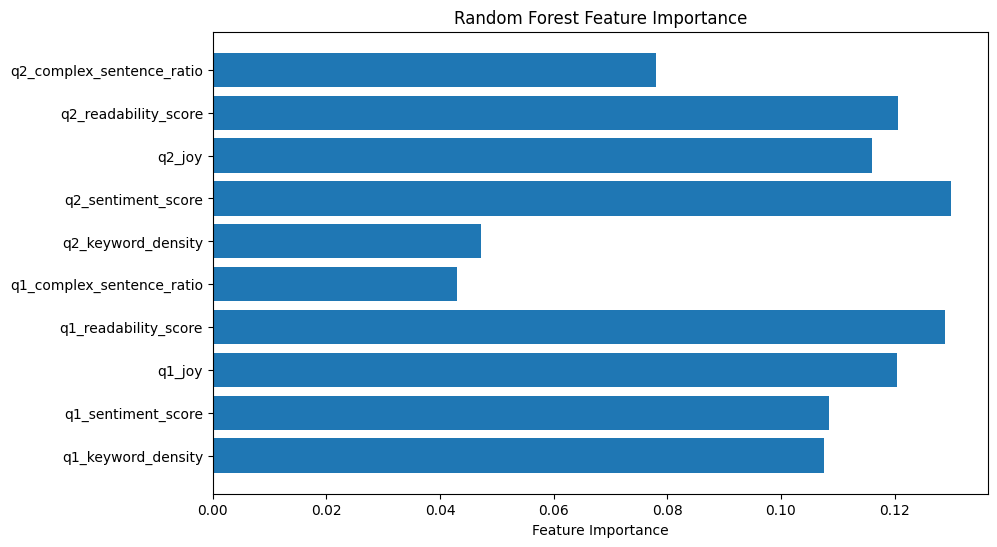

Candidate scores, along with intermediate and final scores, have been successfully saved to 'ranked_candidates.csv'.


In [20]:
importance = model.feature_importances_
features = ['q1_keyword_density', 'q1_sentiment_score', 'q1_joy', 'q1_readability_score', 'q1_complex_sentence_ratio',
            'q2_keyword_density', 'q2_sentiment_score', 'q2_joy', 'q2_readability_score', 'q2_complex_sentence_ratio']

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

print("Candidate scores, along with intermediate and final scores, have been successfully saved to 'ranked_candidates.csv'.")